In [1]:
import os
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Functions

In [2]:
# sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

# initialize_with_zeros
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

# propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A+1e-8)+(1-Y)*np.log(1-A+1e-8),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Gradient descent algorithm

In [3]:
# optimize
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

### Stochastic gradient descent algorithm

In [4]:
def stochastic_gradient_descent(w, b, X, y, num_iterations, learning_rate, batch_size, print_cost=False):
    m = X.shape[1]
    costs = []

    for i in range(num_iterations):
        # Get mini-batches
        batch_indices = np.random.randint(low=0, high=m, size=batch_size)
        X_batch = X[:, batch_indices]
        y_batch = y[:, batch_indices]

        # Cost and gradient calculation for the mini-batch
        grads, cost = propagate(w, b, X_batch, y_batch)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # Update rule
        w -= learning_rate * dw
        b -= learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))

    return w, b, costs

### Adam optimization method

In [5]:
def adam_optimization(w, b, X, y, num_iterations, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=False):
    m = X.shape[1]
    costs = []
    vdw = np.zeros_like(w)
    vdb = np.zeros_like(b)
    sdw = np.zeros_like(w)
    sdb = np.zeros_like(b)

    for i in range(num_iterations):
        # Cost and gradient calculation for the mini-batch
        grads, cost = propagate(w, b, X, y)
        dw = grads["dw"]
        db = grads["db"]

        # Update biased first and second moment
        vdw = beta1 * vdw + (1 - beta1) * dw
        vdb = beta1 * vdb + (1 - beta1) * db
        sdw = beta2 * sdw + (1 - beta2) * np.power(dw, 2)
        sdb = beta2 * sdb + (1 - beta2) * np.power(db, 2)

        # Correct bias in first and second moment
        vdw_corrected = vdw / (1 - np.power(beta1, i+1))
        vdb_corrected = vdb / (1 - np.power(beta1, i+1))
        sdw_corrected = sdw / (1 - np.power(beta2, i+1))
        sdb_corrected = sdb / (1 - np.power(beta2, i+1))

        # Update rule
        w = w - learning_rate * vdw_corrected / (np.sqrt(sdw_corrected) + epsilon)
        b = b - learning_rate * vdb_corrected / (np.sqrt(sdb_corrected) + epsilon)

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))

    return w, b, costs

### Load data

In [6]:
dataset = pd.read_csv(os.path.join('data', 'bioresponse.csv'))

In [7]:
dataset.head(5)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


### Data preprocessing

In [8]:
X = dataset.drop('Activity', axis=1).values
y = dataset.loc[:, 'Activity'].values

In [9]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1.	Apply the logistic regression method using the functions in the notebook «Logistic Regression as a Neural Network – BP alg.ipynb” to predict the biological response of a molecule.

In [11]:
w = np.zeros((X_train.shape[1], 1))
b = 0

num_iterations = 1000
learning_rate = 0.015

params, _, costs = optimize(
    w=w,
    b=b,
    X=X_train.T,
    Y=y_train.reshape(1, -1),
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    print_cost=True
)

w = params['w']
b = params['b']

pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

print(f"Test accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)}")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.444632
Cost after iteration 200: 0.402491
Cost after iteration 300: 0.379448
Cost after iteration 400: 0.363717
Cost after iteration 500: 0.351797
Cost after iteration 600: 0.342206
Cost after iteration 700: 0.334183
Cost after iteration 800: 0.327289
Cost after iteration 900: 0.321246
Test accuracy: 0.7537


### 2.	Appling stochastic gradient descent algorithm.

In [12]:
w = np.zeros((X_train.shape[1], 1))
b = 0

num_iterations = 1000
learning_rate = 0.01
batch_size = 128

w, b, costs_sgd = stochastic_gradient_descent(
    w=w,
    b=b,
    X=X_train.T,
    y=y_train.reshape(1, -1),
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    batch_size=batch_size,
    print_cost=True
)

pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

print(f"Test accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)}")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.485629
Cost after iteration 200: 0.420051
Cost after iteration 300: 0.404892
Cost after iteration 400: 0.414664
Cost after iteration 500: 0.315581
Cost after iteration 600: 0.354355
Cost after iteration 700: 0.395128
Cost after iteration 800: 0.337095
Cost after iteration 900: 0.260348
Test accuracy: 0.7463


### 3.	Appling Adam optimization method.

In [13]:
w = np.zeros((X_train.shape[1], 1))
b = 0

num_iterations = 1000
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

w, b, costs_adam = adam_optimization(
    w=w,
    b=b,
    X=X_train.T,
    y=y_train.reshape(1, -1),
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    beta1=beta1,
    beta2=beta2,
    epsilon=epsilon,
    print_cost=True
)

pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

print(f"Test accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)}")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.238639
Cost after iteration 200: 0.194396
Cost after iteration 300: 0.170220
Cost after iteration 400: 0.153912
Cost after iteration 500: 0.141655
Cost after iteration 600: 0.131822
Cost after iteration 700: 0.123595
Cost after iteration 800: 0.116518
Cost after iteration 900: 0.110312
Test accuracy: 0.7132


### 4. Plot the learning curves

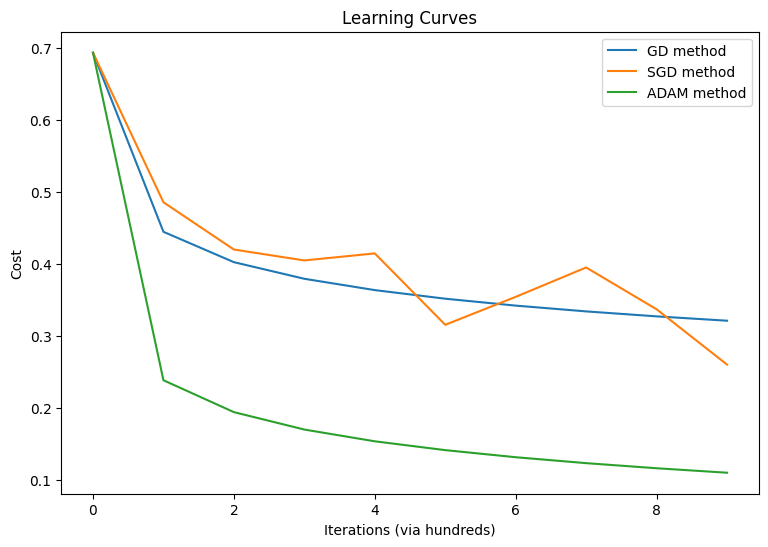

In [14]:
plt.figure(figsize=(9, 6))
plt.plot(costs, label="GD method")
plt.plot(costs_sgd, label="SGD method")
plt.plot(costs_adam, label="ADAM method")
plt.xlabel("Iterations (via hundreds)")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.show()

### 5. Appling models with different values of the learning rate.

In [15]:
learning_rate_list = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
models = {}

for i, temp_learning_rate in enumerate(learning_rate_list):

    START_ITER_TIME = time.time()

    # GD
    START_ITER_TIME_VIA_GD = time.time()

    # Initialize weights and biases
    w = np.zeros((X_train.shape[1], 1))
    b = 0

    num_iterations = 1000

    params, _, _ = optimize(
        w=w,
        b=b,
        X=X_train.T,
        Y=y_train.reshape(1, -1),
        num_iterations=num_iterations,
        learning_rate=temp_learning_rate,
        print_cost=False
    )
    models[str(temp_learning_rate)] = {
        "GD": {
            'w': params['w'],
            'b': params['b']
        }
    }
    print(f"In order to fit model via GD with {temp_learning_rate} it takes {np.round(time.time() - START_ITER_TIME_VIA_GD)} sec")

    # SGD
    START_ITER_TIME_VIA_SGD = time.time()

    # Initialize weights and biases
    w = np.zeros((X_train.shape[1], 1))
    b = 0
    
    num_iterations = 1000
    batch_size = 32

    temp_w_sgd, temp_b_sgd, _ = stochastic_gradient_descent(
        w=w,
        b=b,
        X=X_train.T,
        y=y_train.reshape(1, -1),
        num_iterations=num_iterations,
        learning_rate=temp_learning_rate,
        batch_size=batch_size,
        print_cost=False
    )
    models[str(temp_learning_rate)]['SGD'] = {
        'w': temp_w_sgd,
        'b': temp_b_sgd
    }
    print(f"In order to fit model via SGD with {temp_learning_rate} it takes {np.round(time.time() - START_ITER_TIME_VIA_SGD)} sec")

    # ADAM
    START_ITER_TIME_VIA_ADAM = time.time()

    # Initialize weights and biases
    w = np.zeros((X_train.shape[1], 1))
    b = 0
    
    num_iterations = 1000
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    temp_w_adam, temp_b_adam, _ = adam_optimization(
        w=w,
        b=b,
        X=X_train.T,
        y=y_train.reshape(1, -1),
        num_iterations=num_iterations,
        learning_rate=temp_learning_rate,
        beta1=beta1,
        beta2=beta2,
        epsilon=epsilon,
        print_cost=False
    )
    models[str(temp_learning_rate)]['ADAM'] = {
        'w': temp_w_adam,
        'b': temp_b_adam
    }
    print(f"In order to fit model via ADAM with {temp_learning_rate} it takes {np.round(time.time() - START_ITER_TIME_VIA_ADAM)} sec")

    print(f"Iter time: {np.round(time.time() - START_ITER_TIME)} sec")
    print()

In order to fit model via GD with 0.1 it takes 2.0 sec
In order to fit model via SGD with 0.1 it takes 0.0 sec
In order to fit model via ADAM with 0.1 it takes 2.0 sec
Iter time: 4.0 sec

In order to fit model via GD with 0.05 it takes 2.0 sec
In order to fit model via SGD with 0.05 it takes 0.0 sec
In order to fit model via ADAM with 0.05 it takes 2.0 sec
Iter time: 4.0 sec

In order to fit model via GD with 0.01 it takes 2.0 sec
In order to fit model via SGD with 0.01 it takes 0.0 sec
In order to fit model via ADAM with 0.01 it takes 2.0 sec
Iter time: 4.0 sec

In order to fit model via GD with 0.005 it takes 2.0 sec
In order to fit model via SGD with 0.005 it takes 0.0 sec
In order to fit model via ADAM with 0.005 it takes 2.0 sec
Iter time: 4.0 sec

In order to fit model via GD with 0.001 it takes 2.0 sec
In order to fit model via SGD with 0.001 it takes 0.0 sec
In order to fit model via ADAM with 0.001 it takes 2.0 sec
Iter time: 4.0 sec

In order to fit model via GD with 0.0005 i

### 6. Comparing the accuracy of fitted models.

In [16]:
best_model = None
best_accuracy_score = 0
for learning_rate in models:
    for model_name in models[learning_rate]:
        w, b = models[learning_rate][model_name]['w'], models[learning_rate][model_name]['b']

        pred_proba = np.dot(w.T, X_test.T) + b
        pred = np.where(pred_proba > 0.5, 1, 0).ravel()
        temp_accuracy_score = np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)
        
        print(f"Test accuracy via model {model_name} with learning_rate {learning_rate}: {temp_accuracy_score}")

        if temp_accuracy_score > best_accuracy_score:
            best_accuracy_score = temp_accuracy_score
            best_model = f"Model {model_name} with learning_rate {learning_rate}"
    print()

print(f"Best model: {best_model}")
print(f"Best accuracy_score: {best_accuracy_score}")

Test accuracy via model GD with learning_rate 0.1: 0.7367
Test accuracy via model SGD with learning_rate 0.1: 0.7345
Test accuracy via model ADAM with learning_rate 0.1: 0.6908

Test accuracy via model GD with learning_rate 0.05: 0.7473
Test accuracy via model SGD with learning_rate 0.05: 0.7292
Test accuracy via model ADAM with learning_rate 0.05: 0.7015

Test accuracy via model GD with learning_rate 0.01: 0.7537
Test accuracy via model SGD with learning_rate 0.01: 0.7612
Test accuracy via model ADAM with learning_rate 0.01: 0.7132

Test accuracy via model GD with learning_rate 0.005: 0.7409
Test accuracy via model SGD with learning_rate 0.005: 0.7516
Test accuracy via model ADAM with learning_rate 0.005: 0.7143

Test accuracy via model GD with learning_rate 0.001: 0.7026
Test accuracy via model SGD with learning_rate 0.001: 0.7004
Test accuracy via model ADAM with learning_rate 0.001: 0.726

Test accuracy via model GD with learning_rate 0.0005: 0.6684
Test accuracy via model SGD with